In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=a53c04d0efbfc5ae40bb3343656ad489f840b6576135e2cdaa6c9d0337c5b4c0
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [ ]:
import networkx as nx

# Load the graph from the file
all_network = nx.read_graphml('/content/all_network.graphml')
print("Graph has been loaded from all_network.graphml")


Graph has been loaded from all_network.graphml



# Model Validation through Expert-Based Fuzzy Behavioral Assessment
To support the preliminary validation of the model’s predictive capacity, we conducted an expert-based fuzzy evaluation aimed at estimating the actual safety behavior profile of the safety department under study. This assessment was grounded in a conceptual framework informed by STAMP (System-Theoretic Accident Model and Processes; Leveson, 2004) and principles of adaptive control. Within this framework, safe behavior in an organizational control unit is operationally defined as the degree to which its members actively engage in sensing, actuating, and updating the internal mechanisms that maintain a valid and adaptive mental model of the system under control.

Given the absence of formalized performance indicators for departmental-level safety behavior, we employed a structured triangulation of expert judgments. The evaluation involved three independent raters: the department’s safety manager, a senior technical staff member, and the author of this study, who also serves as a full-time employee within the unit. The dual role of the author—as both researcher and embedded safety professional—provided a unique integrative perspective based on direct observation and longitudinal involvement.

Each evaluator rated the safety behavior of all nine personnel in the department using a five-point Likert scale (1 = Very Low to 5 = Very High). These ratings were then transformed into fuzzy membership vectors across three linguistic categories—Low, Medium, and High—through a triangular fuzzification process, in line with established linguistic decision analysis methods (Herrera & Herrera-Viedma, 2000). The resulting 27 fuzzy assessments (9 individuals × 3 raters) were averaged to form a single, composite fuzzy estimate of the department’s collective safety behavior.

This expert-derived fuzzy profile was then compared to the FCM model’s predicted behavioral output under the matching input scenario. The close qualitative alignment between the expert-based evaluation and the simulation result provides initial evidence of the model’s face validity. Furthermore, the use of fuzzy linguistic representation enabled a semantically consistent comparison between human judgment and model prediction, reinforcing the interpretability of the simulation outputs.



In [ ]:
# ======================================================
# 📘 Self-Contained FCM Simulation & Expert Comparison Tool (Robust and Visualized)
# ======================================================

# ✅ Import Required Libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import unicodedata
import re
from pyDOE import lhs





# ----------------------------
# uclidean_distance
# ----------------------------

def euclidean_distance(vec1, vec2):
    """
    Compute Euclidean distance between two 3-level fuzzy vectors.
    Accepts both dict or list inputs.
    """
    if isinstance(vec1, dict):
        vec1 = [vec1.get('Low', 0), vec1.get('Medium', 0), vec1.get('High', 0)]
    if isinstance(vec2, dict):
        vec2 = [vec2.get('Low', 0), vec2.get('Medium', 0), vec2.get('High', 0)]
    return np.sqrt(sum((a - b) ** 2 for a, b in zip(vec1, vec2)))

# ----------------------------
# 🧠 Expert Ratings Processing
# ----------------------------

def fuzzify_likert_1to5(val):
    """
    Convert a Likert scale value (1 to 5) into a fuzzy vector [Low, Medium, High].

    Returns:
        List of 3 floats representing degrees of membership to [Low, Medium, High].
    """
    if val == 1:
        return [1.0, 0.0, 0.0]  # completely Low
    elif val == 2:
        return [0.6, 0.4, 0.0]  # mostly Low
    elif val == 3:
        return [0.0, 1.0, 0.0]  # Medium
    elif val == 4:
        return [0.0, 0.4, 0.6]  # mostly High
    elif val == 5:
        return [0.0, 0.0, 1.0]  # completely High
    else:
        raise ValueError(f"Invalid Likert value: {val}. Expected 1 to 5.")


def process_expert_judgment(file_path):
    df = pd.read_excel(file_path)
    ratings = df.iloc[:, 1:]
    all_fuzzy_vectors = []
    for col in ratings.columns:
        for val in ratings[col]:
            fuzzy_vec = fuzzify_likert_1to5(val)
            all_fuzzy_vectors.append(fuzzy_vec)
    avg_fuzzy = np.mean(all_fuzzy_vectors, axis=0)
    defuzz_list = [defuzzify({'Low': v[0], 'Medium': v[1], 'High': v[2]}) for v in all_fuzzy_vectors]
    return avg_fuzzy, defuzz_list



# --------------------------
# 📦 Import Required Libraries
# --------------------------
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyDOE import lhs
import unicodedata
import re

# --------------------------
# 🔧 Preprocessing Functions
# --------------------------
def clean_node_name(name):
    """
    Normalize and clean node names for reliable matching.
    """
    name = str(name).strip().lower()
    name = unicodedata.normalize("NFKD", name)
    name = re.sub(r'[\u200b-\u200f\u202a-\u202e\u00a0]', '', name)
    return name

def fuzzify_bsp_input(value):
    """
    Convert a crisp or linguistic BSP input to a 5-level fuzzy vector.
    """
    if isinstance(value, str):
        value = value.strip().lower()
        mapping = {
            "very low": [1, 0, 0, 0, 0],
            "low":      [0, 1, 0, 0, 0],
            "medium":   [0, 0, 1, 0, 0],
            "high":     [0, 0, 0, 1, 0],
            "very high":[0, 0, 0, 0, 1]
        }
        return mapping.get(value, [0, 0, 1, 0, 0])
    else:
        x = float(value)
        return [
            max(0, 1 - 4 * x),
            max(0, 1 - abs(4 * x - 1)),
            max(0, 1 - abs(4 * x - 2)),
            max(0, 1 - abs(4 * x - 3)),
            max(0, 4 * x - 3) if x >= 0.75 else 0
        ]

def triangular_membership(x, a, b, c):
    """
    Calculate membership value of x in a triangular fuzzy set.
    """
    if x < a or x > c: return 0.0
    elif x == b: return 1.0
    elif x < b: return (x - a) / (b - a)
    else: return (c - x) / (c - b)

def fuzzify_output(x):
    """
    Convert a crisp value to a 3-level fuzzy output.
    """
    return {
        'Low': triangular_membership(x, -1, -1, 0),
        'Medium': triangular_membership(x, -1, 0, 1),
        'High': triangular_membership(x, 0, 1, 1)
    }

def defuzzify(fuzzy_vector):
    """
    Convert a fuzzy vector (Low/Medium/High or Very Low/.../Very High) to a crisp value.
    """
    mapping_3 = {'Low': -1, 'Medium': 0, 'High': 1}
    mapping_5 = {'Very Low': -1, 'Low': -0.5, 'Medium': 0, 'High': 0.5, 'Very High': 1}

    labels = set(fuzzy_vector.keys())
    if labels <= set(mapping_3.keys()):
        mapping = mapping_3
    elif labels <= set(mapping_5.keys()):
        mapping = mapping_5
    else:
        raise ValueError(f"Unrecognized fuzzy labels: {labels}")

    numerator = sum(mapping[k] * v for k, v in fuzzy_vector.items())
    denominator = sum(fuzzy_vector.values())
    return numerator / denominator if denominator != 0 else 0

# --------------------------
# 📊 FCM Structure and Initialization
# --------------------------
def graph_to_fcm(g, weight_property="weight", normalize=True):
    """
    Convert a NetworkX graph to an adjacency matrix.
    """
    nodes = list(g.nodes())
    idx = {n: i for i, n in enumerate(nodes)}
    W = np.zeros((len(nodes), len(nodes)))
    for u, v, d in g.edges(data=True):
        w = float(d.get(weight_property, 1))
        W[idx[u], idx[v]] = (w / 5.0) if normalize else w
    return W

def initialize_fcm_state_fuzzy_final(graph, bsp_inputs):
    """
    Initialize FCM node states, identifying random, root, and output nodes.
    """
    init_state = {}
    rand_nodes, root_nodes, out_nodes = [], [], []
    for i, (node, data) in enumerate(graph.nodes(data=True)):
        name = clean_node_name(data.get("name", str(node)))
        label = clean_node_name(data.get("label", str(node)))
        is_random = "random" in name
        is_behavior = re.search(r"_behavior_\d+$", label or "")
        is_bsp = name in bsp_inputs
        is_root = graph.in_degree(node) == 0
        if is_random:
            init_state[i] = np.random.uniform(-1, 1)
            rand_nodes.append(i)
        elif is_bsp:
            vec = bsp_inputs[name]
            init_state[i] = {k: float(v) for k, v in zip(["Very Low", "Low", "Medium", "High", "Very High"], vec)}
        elif is_behavior:
            out_nodes.append(i)
            init_state[i] = fuzzify_output(np.random.uniform(-1, 1))
        else:
            init_state[i] = np.random.uniform(-1, 1)
        if is_root: root_nodes.append(i)
    return init_state, rand_nodes, root_nodes, out_nodes

# --------------------------
# 🔁 Core FCM Simulation
# --------------------------
def nonlinear_transition(wsum, wtot, alpha=1.5):
    return np.tanh(alpha * wsum / wtot) if wtot != 0 else 0.0

def fcm_simulation(W, init_state, root_nodes, rand_nodes, out_nodes, n_iter=10):
    """
    Run one FCM simulation over time steps.
    """
    S = init_state.copy()
    for _ in range(n_iter):
        S_next = {}
        for i in range(W.shape[0]):
            if i in root_nodes or i in rand_nodes:
                S_next[i] = S[i]
                continue
            wsum, wtot = 0, 0
            for j in range(W.shape[0]):
                w = W[j, i]
                if w == 0: continue
                x = defuzzify(S[j]) if isinstance(S[j], dict) else S[j]
                wsum += w * x
                wtot += abs(w)
            res = nonlinear_transition(wsum, wtot)
            S_next[i] = fuzzify_output(res) if i in out_nodes else res
        S = S_next
    return S

# --------------------------
# 📈 LHS Sampling and Aggregation
# --------------------------
def determine_lhs_sample_size(n_rand):
    """Determine number of LHS samples based on random node count."""
    if n_rand <= 5: return 100
    elif n_rand <= 10: return 200
    elif n_rand <= 20: return 300
    else: return 500

def run_lhs_simulation(graph, W, bsp_inputs, rand_nodes, root_nodes, out_nodes, n_iter=10):
    d = len(rand_nodes)
    n_samples = determine_lhs_sample_size(d)
    lhs_samples = lhs(d, samples=n_samples) * 2 - 1
    fuzzy_agg_list = []
    defuzz_agg_list = []
    for s in lhs_samples:
        init_state, _, _, _ = initialize_fcm_state_fuzzy_final(graph, bsp_inputs)
        for idx, val in zip(rand_nodes, s):
            init_state[idx] = val
        final = fcm_simulation(W, init_state, root_nodes, rand_nodes, out_nodes, n_iter=n_iter)
        # Fuzzy aggregation
        fuzzy_vals = [final[i] for i in out_nodes]
        agg = {'Low': 0, 'Medium': 0, 'High': 0}
        for f in fuzzy_vals:
            for k in agg:
                agg[k] += f.get(k, 0)
        for k in agg:
            agg[k] /= len(fuzzy_vals)
        fuzzy_agg_list.append(agg)
        # Defuzzified aggregation
        defuzz_vals = [defuzzify(final[i]) for i in out_nodes]
        defuzz_agg_list.append(np.mean(defuzz_vals))
    return fuzzy_agg_list, defuzz_agg_list

# --------------------------
# 📊 Visualization & Summary
# --------------------------
def plot_fuzzy_bar(fuzzy_agg_mean):
    plt.figure(figsize=(6, 1.2))
    colors = ['red', 'orange', 'green']
    levels = ['Low', 'Medium', 'High']
    if isinstance(fuzzy_agg_mean, (list, np.ndarray)):
      fuzzy_agg_mean = dict(zip(levels, fuzzy_agg_mean))
    start = 0
    for lvl, color in zip(levels, colors):
        width = fuzzy_agg_mean[lvl]
        plt.barh(0, width, left=start, color=color, edgecolor='black')
        start += width
    plt.xlim(0, 1)
    plt.yticks([])
    plt.title("Fuzzy Aggregated Output")
    plt.show()

def plot_defuzzified_bar_normalized(defuzz_results):
    """
    Visualize defuzzified outputs mapped to [0,1] for visual consistency with fuzzy outputs.
    """
    # Map defuzzified results from [-1,1] → [0,1]
    norm_results = [(x + 1) / 2 for x in defuzz_results]
    mean = np.mean(norm_results)
    low = np.percentile(norm_results, 5)
    high = np.percentile(norm_results, 95)

    plt.figure(figsize=(6, 1.2))
    plt.barh(0, 1, left=0, color='lightgray', edgecolor='black')  # background bar
    plt.plot(mean, 0, 'ko', label='Mean')
    plt.errorbar(mean, 0, xerr=[[mean - low], [high - mean]], fmt='o', color='black', capsize=5)

    plt.xlim(0, 1)
    plt.yticks([])
    plt.xlabel("Defuzzified score (rescaled to 0–1)")
    plt.title("Normalized Defuzzified Output with 90% CI")
    plt.tight_layout()
    plt.show()

def summarize_defuzzified(defuzz_results):
    """
    Generate a summary table with uncertainty metrics and definitions.
    """
    summary = {
        "Mean": np.mean(defuzz_results),
        "Std Dev": np.std(defuzz_results),
        "Min": np.min(defuzz_results),
        "Max": np.max(defuzz_results),
        "5th Percentile": np.percentile(defuzz_results, 5),
        "95th Percentile": np.percentile(defuzz_results, 95),
        "95% CI Width": np.percentile(defuzz_results, 95) - np.percentile(defuzz_results, 5)
    }
    definitions = {
        "Mean": "Average system-level behavior score.",
        "Std Dev": "Standard deviation indicating variation across samples.",
        "Min": "Lowest observed output in the simulations.",
        "Max": "Highest observed output in the simulations.",
        "5th Percentile": "Lower bound of 90% confidence interval.",
        "95th Percentile": "Upper bound of 90% confidence interval.",
        "95% CI Width": "Spread of the 90% confidence range (sensitivity width)."
    }
    df = pd.DataFrame.from_dict(summary, orient='index', columns=["Value"])
    df["Definition"] = df.index.map(definitions)
    return df


# --------------------------
# 🧠 Final Simulation Function
# --------------------------
def run_full_simulation(graph_file, excel_file):
    G = nx.read_graphml(graph_file)
    df = pd.read_excel(excel_file)
    df.columns = df.columns.str.strip().str.lower()
    bsp_inputs = {clean_node_name(row['name']): fuzzify_bsp_input(row['value']) for _, row in df.iterrows()}
    W = graph_to_fcm(G)
    init_state, rand_nodes, root_nodes, out_nodes = initialize_fcm_state_fuzzy_final(G, bsp_inputs)
    fuzzy_results, defuzz_results = run_lhs_simulation(G, W, bsp_inputs, rand_nodes, root_nodes, out_nodes)
    fuzzy_avg = {
        'Low': np.mean([f['Low'] for f in fuzzy_results]),
        'Medium': np.mean([f['Medium'] for f in fuzzy_results]),
        'High': np.mean([f['High'] for f in fuzzy_results])
    }
    plot_fuzzy_bar(fuzzy_avg)
    plot_defuzzified_bar_normalized(defuzz_results)
    summary_df = summarize_defuzzified(defuzz_results)
    return fuzzy_avg, defuzz_results, summary_df



# ----------------------------
# ✅ Final Comparison & Report
# ----------------------------

def compare_model_to_expert(model_vec, expert_vec, expert_defuzz_list):
    d_model = defuzzify(model_vec)
    d_expert = defuzzify({'Low': expert_vec[0], 'Medium': expert_vec[1], 'High': expert_vec[2]})
    euclid = euclidean_distance(model_vec, {'Low': expert_vec[0], 'Medium': expert_vec[1], 'High': expert_vec[2]})
    print("\n🔍 Comparison Summary:")
    print(f"Model defuzzified: {d_model:.3f} | Expert defuzzified: {d_expert:.3f}")
    print(f"Absolute difference: {abs(d_model - d_expert):.3f}")
    print(f"Euclidean distance (fuzzy vectors): {euclid:.3f}")




 Model Output:


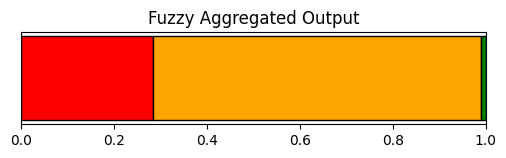

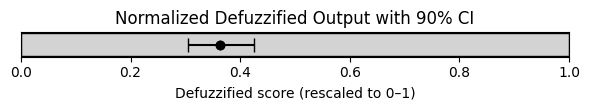


 Expert Result:


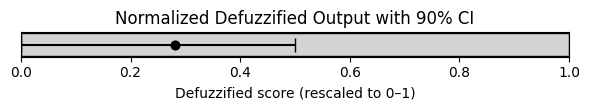

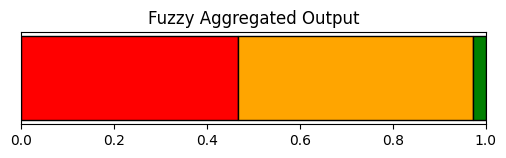


🔍 Comparison Summary:
Model defuzzified: -0.275 | Expert defuzzified: -0.438
Absolute difference: 0.164
Euclidean distance (fuzzy vectors): 0.271


In [ ]:
# Befor Executeing Upload "all_network.graphml", "fcm_input_template.xlsx", and "expert_ratings.xlsx"

print("\n Model Output:")
fuzzy_output, defuzz_values, summary_table = run_full_simulation("all_network.graphml", "fcm_input_template.xlsx")
print("\n Expert Result:")
avg_fuzzy, defuzz_list = process_expert_judgment("expert_ratings.xlsx")
plot_defuzzified_bar_normalized(defuzz_list)
plot_fuzzy_bar(avg_fuzzy)
compare_model_to_expert(fuzzy_output, avg_fuzzy, defuzz_list)

In [2]:
import pandas as pd
import numpy as np

def compute_sdi(file_path):
    """
    Compute SDI (Standard Deviation Index) for expert ratings.

    Parameters:
    - file_path: Path to Excel file with expert Likert ratings (1–5).
                 First column = individual/team member name.
                 Remaining columns = ratings from each expert.

    Returns:
    - sdi (float): Average standard deviation across raters.
    - stds (Series): Standard deviation per individual.
    """

    df = pd.read_excel(file_path)
    ratings = df.iloc[:, 1:]  # Exclude name column
    stds = ratings.std(axis=1)
    sdi = stds.mean()

    print("\n🔍 Inter-Rater Disagreement Summary")
    print(f"SDI (Average Std Dev): {sdi:.3f}")
    print(f"Minimum SD: {stds.min():.3f}")
    print(f"Maximum SD: {stds.max():.3f}")

    # Interpretation
    if sdi < 0.5:
        level = "🟢 High agreement among experts"
    elif sdi < 1.0:
        level = "🟡 Moderate agreement among experts"
    else:
        level = "🔴 Low agreement or high disagreement among experts"

    print(f"Interpretation: {level}")

    return sdi, stds

# Example:
sdi_val, stds_per_person = compute_sdi("expert_ratings.xlsx")



🔍 Inter-Rater Disagreement Summary
SDI (Average Std Dev): 0.412
Minimum SD: 0.000
Maximum SD: 0.577
Interpretation: 🟢 High agreement among experts


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Expert-Based Validation via Fuzzy Vector Comparison
To provide a quantitative basis for validating the predictive accuracy of the FCM simulation model, we implemented a comparison framework that operates on the fuzzy output representations of both the model and expert judgment. The comparison method supports two levels of analysis: defuzzified scalar distance and fuzzy vector similarity.

Each fuzzy vector—representing the final collective safety behavior—is expressed using a three-level linguistic scale: Low, Medium, and High. These vectors are normalized membership distributions derived either from the FCM output or from aggregated expert evaluations. To enable numeric comparison, both vectors are defuzzified using a standard linear transformation, assigning weights of -1.0, 0.0, and +1.0 to the respective membership levels (Herrera & Herrera-Viedma, 2000). The resulting scalar values provide a crisp estimate of the overall behavioral quality.

To assess proximity between the two fuzzy profiles beyond scalar aggregation, we also compute the Euclidean distance between the model-generated and expert-derived fuzzy vectors. This metric preserves the internal distributional structure of the fuzzy ratings, offering a finer-grained perspective on the similarity between the two assessments.

The outputs of the comparison module include:

Defuzzified values for both model and expert vectors

Absolute difference between defuzzified values

Euclidean distance between the full fuzzy vectors

This dual-mode comparison facilitates both interpretability and sensitivity analysis, allowing for validation of the FCM model's predictive realism in a semantically consistent fuzzy framework.

📚 References (APA Style)
Herrera, F., & Herrera-Viedma, E. (2000). Linguistic decision analysis: Steps for solving decision problems under linguistic information. Fuzzy Sets and Systems, 115(1), 67–82. https://doi.org/10.1016/S0165-0114(99)00023-3

